In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import math
import yfinance as yf
import matplotlib.pyplot as plt

yf.pdr_override()

def create_dataset(dataset, look_back=30):
    x, y = [], []
    for i in range(look_back, len(dataset)):
        x.append(dataset[i-look_back:i, 0])
        y.append(dataset[i, 0])
    return np.array(x), np.array(y)

# Load the data
start_date = "2015-01-01"
end_date = "2023-12-12"
df = web.get_data_yahoo('SPY', start=start_date, end=end_date)

# Use only the 'Close' column
data = df.filter(['Close'])

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Calculate the indices for the split
train_data_len = math.ceil(len(scaled_data) * 0.7)
validation_data_len = math.ceil(len(scaled_data) * 0.15)

# Create the training, validation, and testing data set
x_train, y_train = create_dataset(scaled_data[0:train_data_len], look_back=30)
x_val, y_val = create_dataset(scaled_data[train_data_len:train_data_len + validation_data_len], look_back=30)
x_test, y_test = create_dataset(scaled_data[train_data_len + validation_data_len:], look_back=30)

# Reshape data for the models
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Define the models
def build_model(model_type, look_back=30):
    model = Sequential()
    if model_type == 'LSTM':
        model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
        model.add(LSTM(50))
    elif model_type == 'GRU':
        model.add(GRU(50, return_sequences=True, input_shape=(look_back, 1)))
        model.add(GRU(50))
    elif model_type == 'RNN':
        model.add(SimpleRNN(50, return_sequences=True, input_shape=(look_back, 1)))
        model.add(SimpleRNN(50))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Callbacks for early stopping and best model checkpointing
model_types = ['LSTM', 'GRU', 'RNN']

# Function to build and compile models
def build_and_compile_model(model_type):
    model = build_model(model_type)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Dictionary to store the history of each model
model_histories = {}

num_epochs = 100
for model_type in model_types:
    print(f"Training {model_type} model...")
    # Define the callbacks for early stopping and model checkpointing
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    model_checkpoint = ModelCheckpoint(f'best_model_{model_type}.h5', monitor='val_loss', mode='min', save_best_only=True)

    # Build and compile the model
    model = build_and_compile_model(model_type)

    # Train the model
    history = model.fit(
        x_train, y_train,
        batch_size=32,
        epochs=num_epochs,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping, model_checkpoint]
    )

    # Store the history
    model_histories[model_type] = history


2023-11-08 20:24:35.162544: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-08 20:24:35.162568: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-08 20:24:35.162588: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-08 20:24:35.168215: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[*********************100%%**********************]  1 of 1 completed
Training LSTM model...


2023-11-08 20:24:37.350221: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-08 20:24:37.354139: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-08 20:24:37.354306: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/100


2023-11-08 20:24:39.846442: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-08 20:24:40.165908: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f450413a5c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-08 20:24:40.165928: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080, Compute Capability 7.5
2023-11-08 20:24:40.169671: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-08 20:24:40.244899: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 3s 15ms/step - loss: 0.0072 - val_loss: 0.0041
Epoch 2/100
44/48 [==========================>...] - ETA: 0s - loss: 5.4449e-04

/home/an/miniconda3/envs/myenv/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 0s 5ms/step - loss: 5.7707e-04 - val_loss: 0.0012
Epoch 3/100
48/48 [==============================] - 0s 4ms/step - loss: 5.4759e-04 - val_loss: 0.0014
Epoch 4/100
48/48 [==============================] - 0s 4ms/step - loss: 5.0143e-04 - val_loss: 0.0015
Epoch 5/100
48/48 [==============================] - 0s 7ms/step - loss: 4.7046e-04 - val_loss: 0.0011
Epoch 6/100
48/48 [==============================] - 0s 4ms/step - loss: 4.4560e-04 - val_loss: 0.0012
Epoch 7/100
48/48 [==============================] - 0s 5ms/step - loss: 4.1664e-04 - val_loss: 9.6749e-04
Epoch 8/100
48/48 [==============================] - 0s 4ms/step - loss: 3.9807e-04 - val_loss: 0.0012
Epoch 9/100
48/48 [==============================] - 0s 4ms/step - loss: 3.9728e-04 - val_loss: 0.0016
Epoch 10/100
48/48 [==============================] - 0s 4ms/step - loss: 3.6107e-04 - val_loss: 0.0010
Epoch 11/100
48/48 [==============================] - 0s 5ms/step - loss: 3.2915

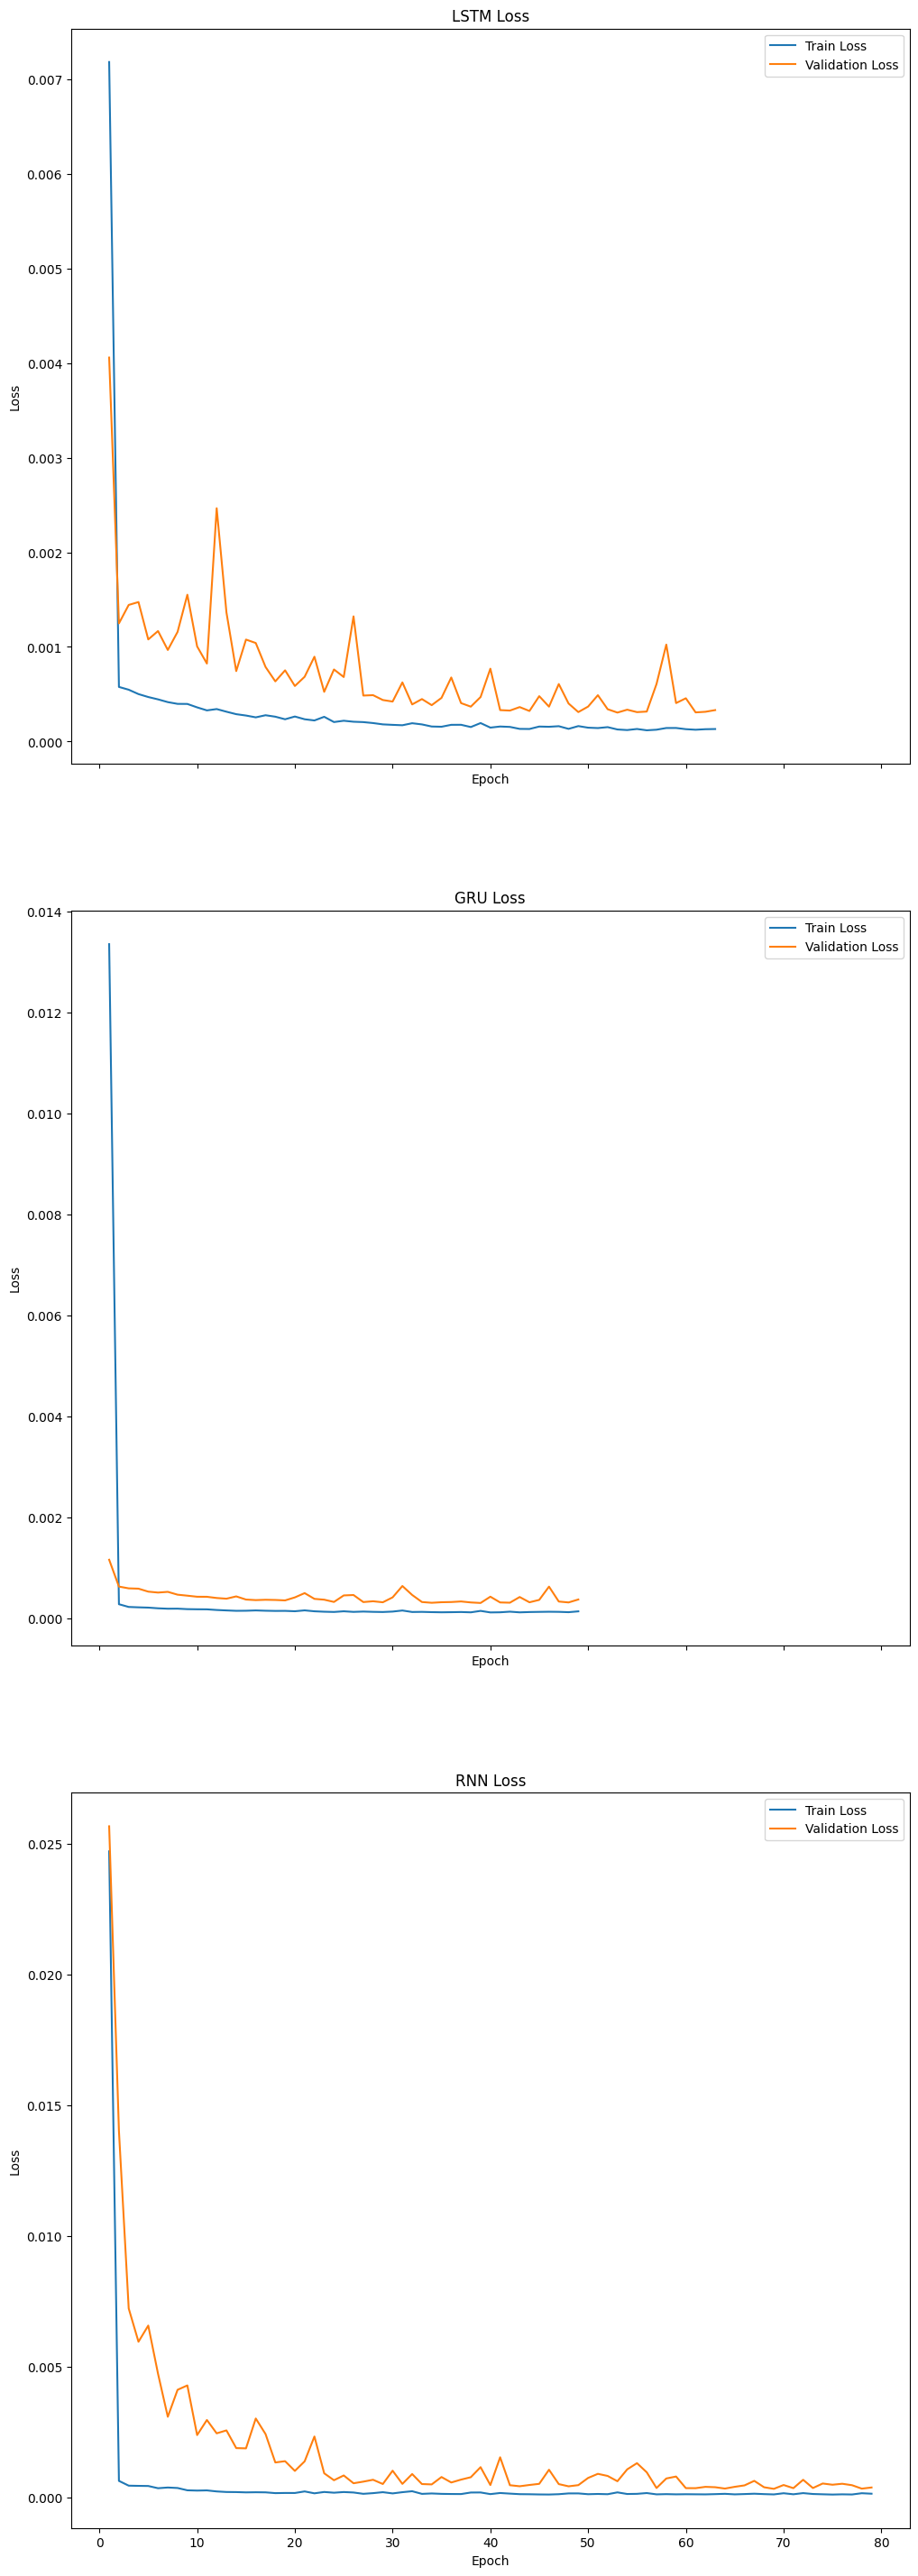

In [13]:
# Plot training & validation loss values for each model type in separate subplots

def plot_loss_subplots(model_histories):
    fig, axes = plt.subplots(nrows=len(model_histories), ncols=1, figsize=(12, 36), sharex=True)

    for ax, (model_type, history) in zip(axes, model_histories.items()):
        epochs = range(1, len(history.history['loss']) + 1)  # Epochs start at 1
        ax.plot(epochs, history.history['loss'], label='Train Loss')
        ax.plot(epochs, history.history['val_loss'], label='Validation Loss')
        ax.set_title(f'{model_type} Loss')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Epoch')  # Set x-label to 'Epoch' for each subplot
        ax.legend()

    plt.show()

plot_loss_subplots(model_histories)


LSTM Model Test Loss: 0.00024513487005606294
10/10 [==============================] - 0s 2ms/step


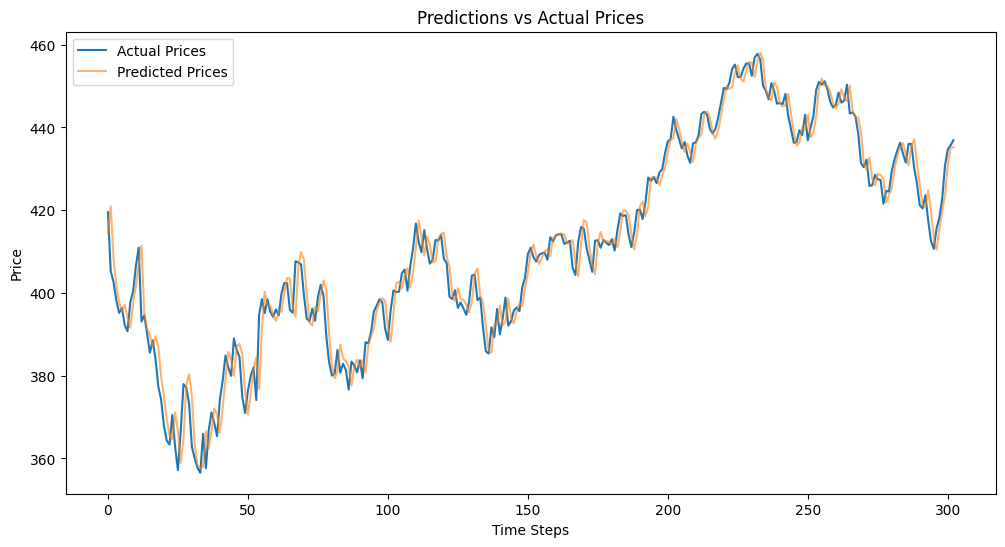

GRU Model Test Loss: 0.00023905865964479744
10/10 [==============================] - 0s 2ms/step


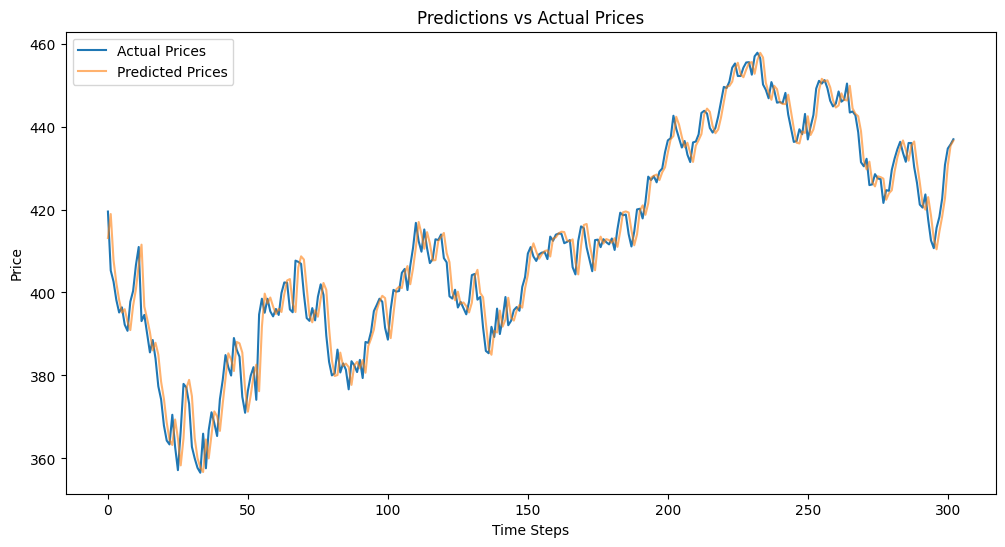

RNN Model Test Loss: 0.00031771179055795074
10/10 [==============================] - 0s 2ms/step


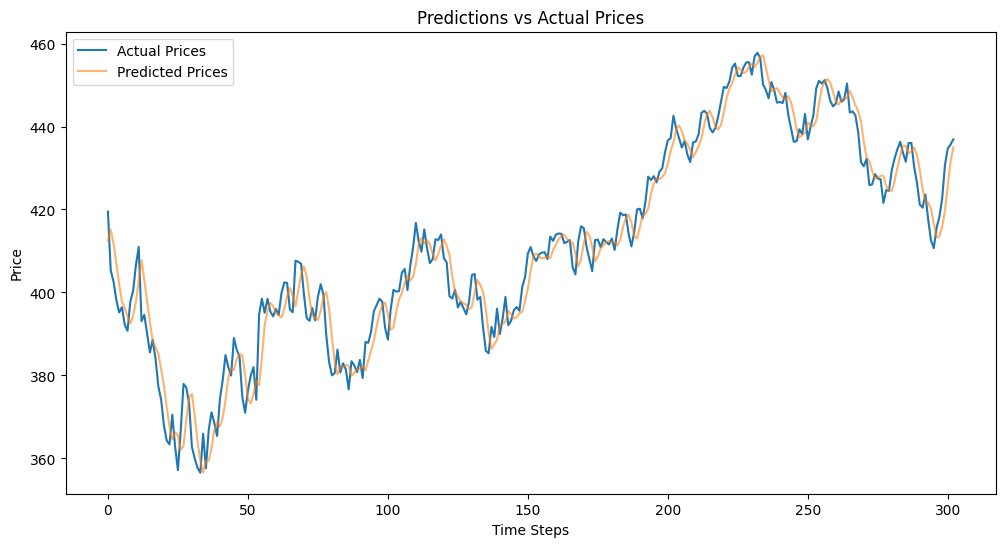

In [16]:
# Load the model, evaluate on the test data, and plot predictions
def evaluate_and_plot(model_type, x_test, y_test, scaler):
    # Load the saved model
    model = load_model(f'best_model_{model_type}.h5')
    plot_predictions(model, x_test, y_test, scaler)

def plot_predictions(model, x_test, y_test, scaler):
    # Make predictions
    test_loss = model.evaluate(x_test, y_test, verbose=0)
    print(f'{model_type} Model Test Loss: {test_loss}')
    predictions = model.predict(x_test)

    # Invert scaling for predictions and actual values
    predictions = scaler.inverse_transform(predictions)
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Plot the predictions against the actual values
    plt.figure(figsize=(12,6))
    plt.plot(actual_prices, label='Actual Prices')
    plt.plot(predictions, label=f'Predicted Prices', alpha=0.6)
    plt.title(f'Predictions vs Actual Prices')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Loop through each model type, evaluate and plot
for model_type in model_types:
    evaluate_and_plot(model_type, x_test, y_test, scaler)


Epoch 1/100
48/48 [==============================] - 3s 15ms/step - loss: 0.0090 - val_loss: 0.0045
Epoch 2/100
40/48 [========================>.....] - ETA: 0s - loss: 5.3466e-04

/home/an/miniconda3/envs/myenv/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 0s 5ms/step - loss: 5.5433e-04 - val_loss: 0.0013
Epoch 3/100
48/48 [==============================] - 0s 5ms/step - loss: 4.9446e-04 - val_loss: 0.0014
Epoch 4/100
48/48 [==============================] - 0s 5ms/step - loss: 4.8139e-04 - val_loss: 0.0012
Epoch 5/100
48/48 [==============================] - 0s 5ms/step - loss: 4.6675e-04 - val_loss: 0.0022
Epoch 6/100
48/48 [==============================] - 0s 5ms/step - loss: 4.6224e-04 - val_loss: 0.0011
Epoch 7/100
48/48 [==============================] - 0s 5ms/step - loss: 4.2897e-04 - val_loss: 0.0012
Epoch 8/100
48/48 [==============================] - 0s 5ms/step - loss: 4.3687e-04 - val_loss: 9.9138e-04
Epoch 9/100
48/48 [==============================] - 0s 5ms/step - loss: 3.9775e-04 - val_loss: 0.0011
Epoch 10/100
48/48 [==============================] - 0s 5ms/step - loss: 3.8274e-04 - val_loss: 8.9493e-04
Epoch 11/100
48/48 [==============================] - 0s 5ms/step - loss: 3.

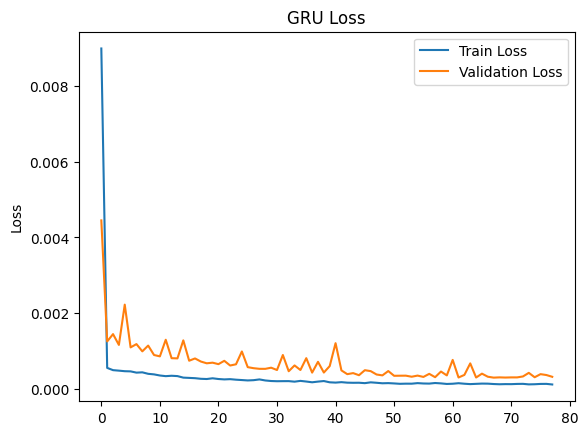

In [7]:
# clipping and train the GRU model again
# Define the callbacks for early stopping and model checkpointing
from tensorflow.keras.optimizers import Adam


early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_checkpoint = ModelCheckpoint(f'best_model_{model_type}.h5', monitor='val_loss', mode='min', save_best_only=True)

# Build and compile the model
model = build_model('LSTM')
optimizer = Adam(clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=num_epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, model_checkpoint]
)

# plot the loss

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('GRU Loss')
plt.ylabel('Loss')
plt.legend()
plt.show()

LSTM Model Test Loss: 0.00024513487005606294
10/10 [==============================] - 0s 2ms/step


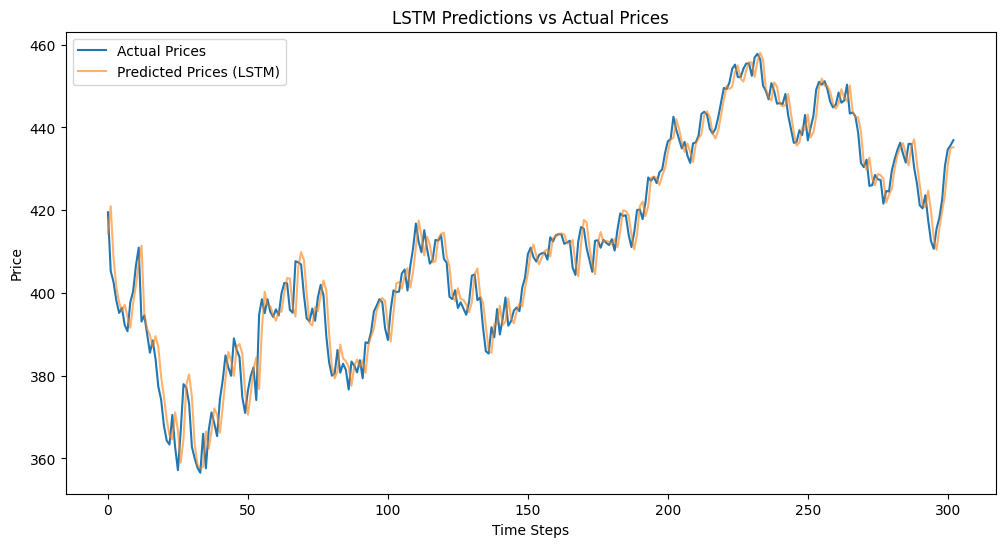

In [10]:
# evaluate and plot the predictions vs actual prices

evaluate_and_plot('LSTM', x_test, y_test, scaler)


Epoch 1/100
48/48 [==============================] - 4s 15ms/step - loss: 0.0151 - val_loss: 0.0014
Epoch 2/100
37/48 [======================>.......] - ETA: 0s - loss: 0.0016

/home/an/miniconda3/envs/myenv/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 3/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 4/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 5/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 6/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 7/100
48/48 [==============================] - 0s 5ms/step - loss: 9.6492e-04 - val_loss: 0.0029
Epoch 8/100
48/48 [==============================] - 0s 5ms/step - loss: 9.4496e-04 - val_loss: 0.0012
Epoch 9/100
48/48 [==============================] - 0s 5ms/step - loss: 9.4559e-04 - val_loss: 0.0022
Epoch 10/100
48/48 [==============================] - 0s 5ms/step - loss: 9.5532e-04 - val_loss: 0.0010
Epoch 11/100
48/48 [==============================] - 0s 5ms/step - loss: 7.7468e-04 - val_loss: 0.0011


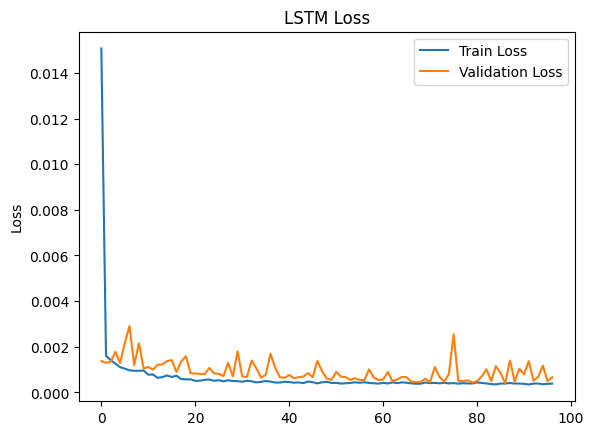

In [14]:
# test drop out for LSTM model

from keras.layers import Dropout

# Define the callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_checkpoint = ModelCheckpoint(f'best_model_{model_type}.h5', monitor='val_loss', mode='min', save_best_only=True)

# Build and compile the model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(30, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model

history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=num_epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, model_checkpoint]
)

# plot the loss

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss')
plt.ylabel('Loss')
plt.legend()
plt.show()

RNN Model Test Loss: 0.0005343073862604797
10/10 [==============================] - 0s 2ms/step


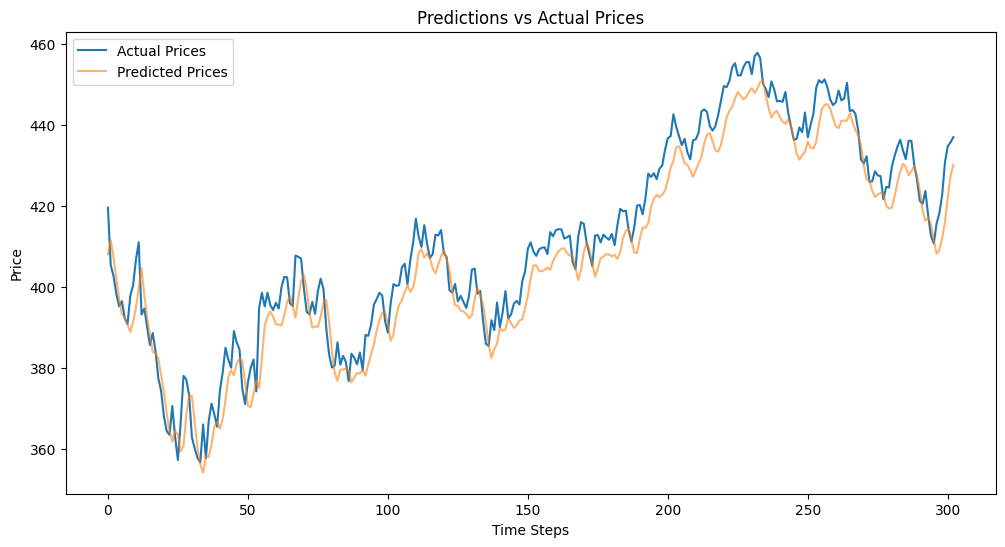

In [17]:
# evaluate and plot the predictions vs actual prices

plot_predictions(model, x_test, y_test, scaler)